<a href="https://colab.research.google.com/github/Sonal-kumar1998/ANN_Based_Device_Modelling/blob/main/Transient_Simulation_25MHZ_pulse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the library

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from keras.models import load_model

#Intanciate the charge and Current Model

In [2]:
class Model(nn.Module):
    def __init__(self,n_feature):
        super(Model, self).__init__()
        self.lin1 = nn.Linear(n_feature,10)
        self.lin2 = nn.Linear(10,10)
        self.lin3 = nn.Linear(10,5)
        self.lin4 = nn.Linear(5,1)
        #self.lin5 = nn.Linear(10,1)
    def forward(self, x):
        x = torch.tanh(self.lin1(x))
        x = torch.tanh(self.lin2(x))
        x = torch.tanh(self.lin3(x))
        x = self.lin4(x)
        #x = self.lin5(x)
        return x
def inv_con_fn(vds, x):
  I_0 = 10**(-12) 
  x = np.power(10,x)
  x = np.multiply(x,vds)
  x  = I_0*x
  return x

In [3]:
# intanciate of AC Model
AC_model_path = "/content/drive/MyDrive/DDP/AC_Model/AC_Model/drain_charge_model.pth"
AC_model = Model(n_feature = 3)
AC_model.load_state_dict(torch.load(AC_model_path))

# intanciate of DC Model
DC_model_path = '/content/drive/MyDrive/DDP/DC_model/Dc_Model/DC_10105.h5'
DC_model= load_model(DC_model_path)

# Preprocess of the input data for model

In [4]:
data_path = "/content/drive/MyDrive/DDP/Transient/Drain_pulse_25MHZ.csv"
data_set = pd.read_csv(data_path)
column_x = ['#"time"',	'i(ntype,d)',	'i(ntype,g)',	'i(ntype,s)',	'i(ntype,b)',	'v(d)',	'v(g)',	'v(s)',	'v(b)']
data_set = data_set[column_x]
#data_set["i(ntype,d)"] = -1 * data_set["i(ntype,d)"]
# data_set = data_set.iloc[117:]
# data_set.to_csv(data_path)

#Plot Drain_voltage verse Time

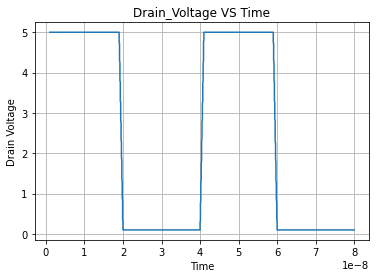

In [5]:
plt.plot(data_set['#"time"'], data_set["v(d)"])
plt.title("Drain_Voltage VS Time")
plt.xlabel("Time")
plt.ylabel("Drain Voltage")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()

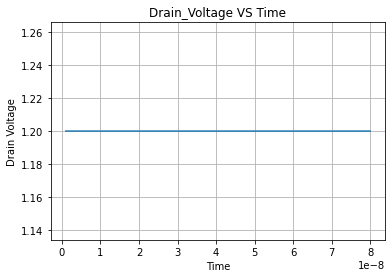

In [6]:
plt.plot(data_set['#"time"'], data_set["v(g)"])
plt.title("Drain_Voltage VS Time")
plt.xlabel("Time")
plt.ylabel("Drain Voltage")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()

In [7]:
# sort the dataframe by time colummn
data_set.sort_values('#"time"')
print(data_set.shape)

# remove the duplicate row with respect to the time
data_set.drop_duplicates(subset = '#"time"', keep = "first", inplace = True)
print(data_set.shape)
data_set.head(5)

(5375, 9)
(797, 9)


,"#""time""","i(ntype,d)","i(ntype,g)","i(ntype,s)","i(ntype,b)",v(d),v(g),v(s),v(b)
0,1.000000e-09,0.000622,-6.090000e-06,0.000627,1.480000e-06,5.0,1.2,-6.570000e-34,0.0
2,1.010000e-09,0.000624,-1.530000e-06,0.000625,4.690000e-08,5.0,1.2,5.130000e-36,0.0
4,1.020000e-09,0.000625,-2.270000e-07,0.000625,-1.010000e-08,5.0,1.2,1.470000e-37,0.0
5,1.030000e-09,0.000625,-5.140000e-08,0.000625,7.570000e-09,5.0,1.2,1.470000e-37,0.0
6,1.050000e-09,0.000625,1.680000e-09,0.000625,1.360000e-08,5.0,1.2,1.470000e-37,0.0


In [8]:
#data_set.to_csv("/content/drive/MyDrive/DDP/Transient/Drain_1KHZtrans.csv")

In [9]:
data_set.tail()

,"#""time""","i(ntype,d)","i(ntype,g)","i(ntype,s)","i(ntype,b)",v(d),v(g),v(s),v(b)
1059,7.970000e-08,0.000047,3.530000e-19,0.000047,1.220000e-16,0.1,1.2,4.830000e-40,0.0
1060,7.980000e-08,0.000047,2.860000e-19,0.000047,1.050000e-16,0.1,1.2,-3.920000e-40,0.0
1061,7.990000e-08,0.000047,2.360000e-19,0.000047,1.220000e-16,0.1,1.2,5.530000e-40,0.0
1062,8.000000e-08,0.000047,2.600000e-19,0.000047,1.050000e-16,0.1,1.2,-3.450000e-40,0.0
1063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# input feature of the model

In [10]:
dc_column = ['v(g)','v(d)', 'v(b)']            #  DC input feature column
ac_column = ["v(d)",	"v(g)",	"v(b)"]          #  AC input feature column
ac_input = data_set[ac_column]
ac_input = torch.tensor(ac_input.values , dtype = torch.float32)
dc_input = data_set[dc_column]
data_time = data_set['#"time"']
voltage = ["v(d)"]
V_ds = data_set[voltage]
Tcad_output = data_set["i(ntype,d)"]
data_set.shape


(797, 9)

#DC current prediction

In [11]:
# DC currrent prediction
DC_predict = DC_model.predict(dc_input)
DC_current = inv_con_fn(V_ds, DC_predict)

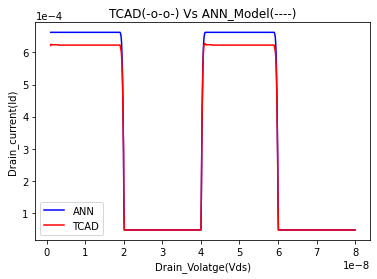

In [12]:
plt.plot(data_time,DC_current, color= "b", markersize = 4 ,label = "ANN")
plt.plot(data_time,Tcad_output,  color= "r", markersize = 4 ,label = "TCAD")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('TCAD(-o-o-) Vs ANN_Model(----)')
plt.ylabel('Drain_current(Id)')
plt.xlabel('Drain_Volatge(Vds)')
plt.legend(loc ="lower left")
plt.savefig("ANN_VS_TCAD ")

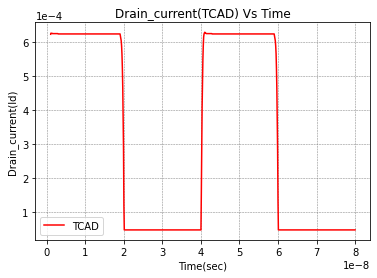

In [13]:
plt.plot(data_time,Tcad_output, color= "r", markersize = 4 ,label = "TCAD")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title('Drain_current(TCAD) Vs Time')
plt.ylabel('Drain_current(Id)')
plt.xlabel('Time(sec)')
plt.legend(loc ="lower left")
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

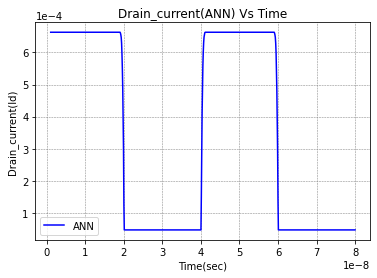

In [14]:
plt.plot(data_time,DC_current, color= "b", markersize = 4 ,label = "ANN")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title('Drain_current(ANN) Vs Time')
plt.ylabel('Drain_current(Id)')
plt.xlabel('Time(sec)')
plt.legend(loc ="lower left")
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

# Charge Prediction

In [15]:
# charge prediction
AC_predict = AC_model(ac_input)
charge = AC_predict/(10**15)
charge = charge.detach().numpy()
charge = list(charge)
data_time = list(data_time)
#print(charge)
#print(data_time)

In [16]:
TCAD_current = []
ANN_current = []
AC_ANN = []
DC_ANN = []
Time = []
for i in range(1,len(charge)):
  delta_Q = float(charge[i]) - float(charge[i-1])
  delta_t = data_time[i]- data_time[i-1]
  delta_i = delta_Q/delta_t

  AC_ANN.append(delta_i)
  ANN_current.append(float(DC_current.iloc[i]) + delta_i)
  
  Time.append(data_time[i])
  TCAD_current.append(Tcad_output.iloc[i])
  DC_ANN.append(float(DC_current.iloc[i]))
  #print(float(DC_current.iloc[i]))

In [17]:
print(len(Time), len(TCAD_current), len(ANN_current))

796 796 796


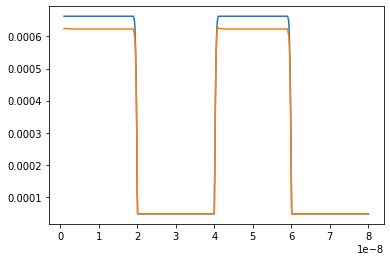

In [18]:
plt.plot(Time, DC_ANN)
plt.plot(Time, TCAD_current)

Text(0.5, 0, 'Time')

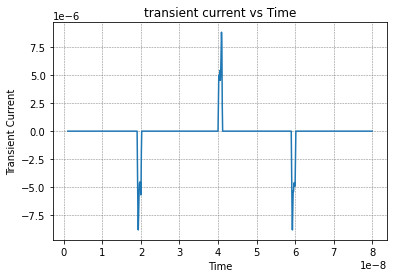

In [19]:
plt.plot(Time, AC_ANN)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.title("transient current vs Time")
plt.ylabel("Transient Current")
plt.xlabel("Time")

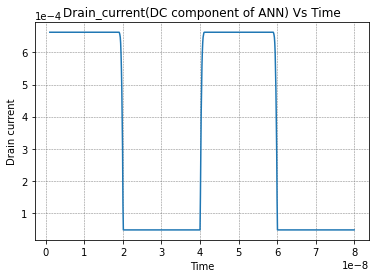

In [20]:
plt.plot(Time, DC_ANN)
plt.title("Drain_current(DC component of ANN) Vs Time")
plt.xlabel("Time")
plt.ylabel("Drain current")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

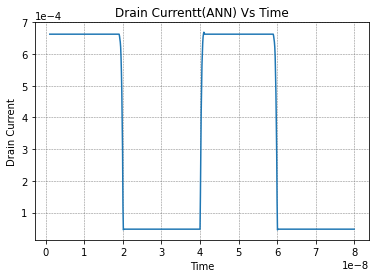

In [21]:
plt.plot(Time,ANN_current)
plt.title("Drain Currentt(ANN) Vs Time")
plt.xlabel("Time")
plt.ylabel("Drain Current")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

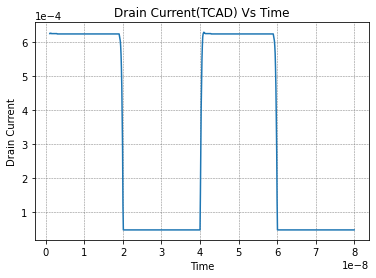

In [22]:
plt.plot(Time, TCAD_current)
plt.title("Drain Current(TCAD) Vs Time")
plt.xlabel("Time")
plt.ylabel("Drain Current")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

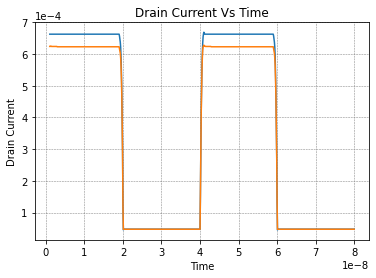

In [23]:
plt.plot(Time,ANN_current)
plt.plot(Time, TCAD_current)
plt.title("Drain Current Vs Time")
plt.xlabel("Time")
plt.ylabel("Drain Current")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

#Relative error
DC component of the Current

In [24]:
ANN_current  = np.array(ANN_current)
TCAD_current = np.array(TCAD_current)
DC_ANN = np.array(DC_ANN).T
DC_error = (DC_ANN - TCAD_current)/TCAD_current*100 
#print(TCAD_current)

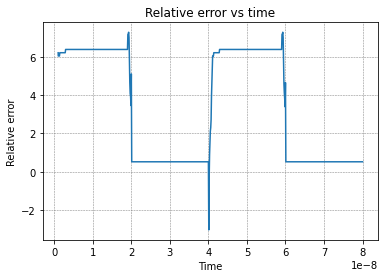

In [25]:
plt.plot(Time, DC_error)
plt.title("Relative error vs time")
plt.ylabel("Relative error")
plt.xlabel("Time")
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

# Relative error of the Current 

In [26]:
ANN_current  = np.array(ANN_current)
TCAD_current = np.array(TCAD_current)
DC_ANN = np.array(DC_ANN).T
error = (ANN_current - TCAD_current)/TCAD_current*100

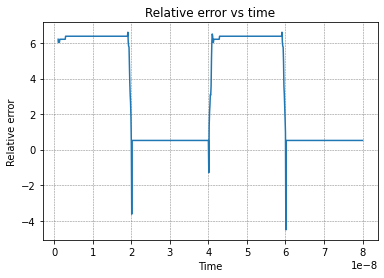

In [27]:
plt.plot(Time, error)
plt.title("Relative error vs time")
plt.ylabel("Relative error")
plt.xlabel("Time")
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.savefig("Relative_Error")